In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from numpy import concatenate

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.metrics import accuracy_score, roc_auc_score, auc, confusion_matrix, roc_curve, classification_report

# (Bonus) Semi-supervised 

Given that half the dataset is unlabled, we wanted to explore semi-supervised algorithms and label propagation. This is not part of the assignement, but an attempt to go a little bit further.

In [2]:
dataset = pd.read_csv('imdb_sup_clean.csv')

In [3]:
X = dataset['join_clean_review']
Y = dataset['label']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=1998)

In [4]:
X_train_lab, X_test_unlab, Y_train_lab, Y_test_unlab = train_test_split(X_train, Y_train, test_size=0.50, random_state=1998)

In [5]:
X_train_lab

59       reliev later review turn sour read posit feedb...
9179     love movi respect midget dress like tini marti...
2151     poor jane austen dog product wonder tongu chee...
6309     ok hollywood liber obvious lie im conserv poli...
9016     talk bad movi nonsens matter fact best movi ev...
                               ...                        
1633     wast minut life turkey gave main charact compl...
1336     bloodi aw way put fact bad reason wast word wa...
8002     film notabl three reason first appar capit suc...
8811     love give kolchak higher rate show quick went ...
10921    movi far cutest seen long time wonder anim ado...
Name: join_clean_review, Length: 2807, dtype: object

In [6]:
X_test_unlab

7071     given titl outlandish box art readi anyth perh...
3400     five minut start feel naff look got complet un...
2268     start plot movi love two high school student w...
5694     much wors origin actual pain sit bare held six...
10031    strong pilot two hour episod excel job set cha...
                               ...                        
3860     betti sizemor rene zellweg secret watch tyrann...
1931     someth wonder reveng film everyon wake morn be...
2034     idea great spoil big time judg make fun peopl ...
3206     wait year see film heard grape vine obvious ex...
2528     watch movi ask think mani notic bad part movi ...
Name: join_clean_review, Length: 2808, dtype: object

In [7]:
X_train_mixed = pd.Series((concatenate((X_train_lab, X_test_unlab))))

In [8]:
X_train_mixed

0       reliev later review turn sour read posit feedb...
1       love movi respect midget dress like tini marti...
2       poor jane austen dog product wonder tongu chee...
3       ok hollywood liber obvious lie im conserv poli...
4       talk bad movi nonsens matter fact best movi ev...
                              ...                        
5610    betti sizemor rene zellweg secret watch tyrann...
5611    someth wonder reveng film everyon wake morn be...
5612    idea great spoil big time judg make fun peopl ...
5613    wait year see film heard grape vine obvious ex...
5614    watch movi ask think mani notic bad part movi ...
Length: 5615, dtype: object

In [9]:
nolabel = [-1 for _ in range(len(Y_test_unlab))]

In [10]:
Y_train_mixed = pd.Series(concatenate((Y_train_lab, nolabel)))

In [11]:
Y_train_mixed

0       0
1       1
2       0
3       0
4       1
       ..
5610   -1
5611   -1
5612   -1
5613   -1
5614   -1
Length: 5615, dtype: int64

In [12]:
tfidf_lp = Pipeline([('vectorizer', TfidfVectorizer(max_features=2000)), ('SVD', TruncatedSVD()),
            ('lab_prop', LabelSpreading())])

In [13]:
tfidf_lp.fit(X_train_mixed, Y_train_mixed)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=2000,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('SVD',
                 TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
                              random_state=None, tol=0.0)),
  

In [14]:
tran_labels = tfidf_lp['lab_prop'].transduction_ #label assigned to each item 

In [15]:
tfidf_log_reg = Pipeline([('vectorizer', TfidfVectorizer(max_features=2000)),
            ('log_reg', LogisticRegression())])
tfidf_log_reg.fit(X_train_mixed, tran_labels)

Y_pred_log_reg = tfidf_log_reg.predict(X_test)

In [16]:
accuracy_score(Y_test, Y_pred_log_reg)

0.7260908281389136

In [17]:
target_names = ['neg','pos']

In [18]:
print(classification_report(Y_test, Y_pred_log_reg, target_names=target_names))

              precision    recall  f1-score   support

         neg       0.76      0.65      0.70      2772
         pos       0.70      0.80      0.75      2843

    accuracy                           0.73      5615
   macro avg       0.73      0.73      0.72      5615
weighted avg       0.73      0.73      0.72      5615



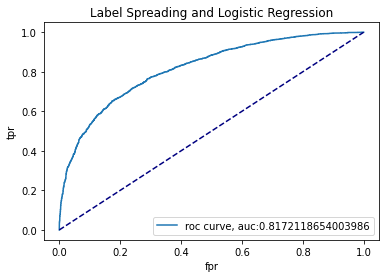

In [19]:
fpr, tpr, threshold = roc_curve(Y_test, tfidf_log_reg.predict_proba(X_test)[:,1])
auc(fpr,tpr)

plt.plot(fpr,tpr,label='roc curve, auc:'+str(auc(fpr,tpr)))
plt.plot([0,1],[0,1],color='navy',linestyle='--')
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.legend(loc=4)
plt.title('Label Spreading and Logistic Regression')
plt.show()